In [2]:
from matplotlib import pyplot as plt
import numpy as np


# 初始波包设置
Lx = 18
Ly = 12
dx = 0.1
dy = 0.1
x0 = 3.05
y0 = 6.0
c = 1
sigmax = 2.75
sigmay = 2.0
k = 5

In [3]:
def update_H(Psi, dt):
    i_forward_Psi = np.zeros_like(Psi)
    i_forward_Psi[1:] = Psi[:-1]
    i_backward_Psi = np.zeros_like(Psi)
    i_backward_Psi[:-1] = Psi[1:]
    j_forward_Psi = np.zeros_like(Psi)
    j_forward_Psi[:, 1:] = Psi[:, :-1]
    j_backward_Psi = np.zeros_like(Psi)
    j_backward_Psi[:, :-1] = Psi[:, 1:]
    Psi[1::2, ::2] += -dt * \
        (j_backward_Psi - j_forward_Psi)[1::2, ::2] / dx  # H_x
    Psi[::2, 1::2] += dt * \
        (i_backward_Psi - i_forward_Psi)[::2, 1::2] / dy  # H_y
    Psi[1, ::2] = Psi[-2, ::2] = Psi[::2, 1] = Psi[::2, -2] = 0


def update_E(Psi, dt):
    i_forward_Psi = np.zeros_like(Psi)
    i_forward_Psi[1:] = Psi[:-1]
    i_backward_Psi = np.zeros_like(Psi)
    i_backward_Psi[:-1] = Psi[1:]
    j_forward_Psi = np.zeros_like(Psi)
    j_forward_Psi[:, 1:] = Psi[:, :-1]
    j_backward_Psi = np.zeros_like(Psi)
    j_backward_Psi[:, :-1] = Psi[:, 1:]
    Psi[1::2, 1::2] += dt * (i_backward_Psi - i_forward_Psi)[1::2, 1::2] / \
        dx - dt * (j_backward_Psi - j_forward_Psi)[1::2, 1::2] / dy  # E_z
    Psi[1, ::2] = Psi[-2, ::2] = Psi[::2, 1] = Psi[::2, -2] = 0

### 生成波包

In [4]:
# 生成格点
x_even = np.arange(dx/2, Lx, dx)
y_even = np.arange(dy/2, Ly, dy)
x_odd = np.arange(0, Lx+dx, dx)
y_odd = np.arange(0, Ly+dy, dy)

X_mn, Y_mn = np.meshgrid(x_odd, y_odd, indexing='ij')
X_Ez, Y_Ez = np.meshgrid(x_even, y_even, indexing='ij')
X_Hx, Y_Hx = np.meshgrid(x_even, y_odd, indexing='ij')
X_Hy, Y_Hy = np.meshgrid(x_odd, y_even, indexing='ij')

n = np.arange(1, 51, 1)
m = np.arange(1, 51, 1)
N, M = np.meshgrid(n, m, indexing='ij')

nx = int(Lx/dx)*2 + 1  # x 方向格点数
ny = int(Ly/dy)*2 + 1  # y 方向格点数

omega = c*np.sqrt((N*np.pi/Lx)**2+(M*np.pi/Ly)**2)

In [5]:
def f(x, y, t) -> np.ndarray:
    """ 初始波包

    Args:
        x: x坐标
        y: y坐标
        t: 时间

    Returns:
        初始波包
    """
    return np.sin(k*(x-x0-t))*np.exp(-((x-x0-t)/sigmax)**10-((y-y0)/sigmay)**2)


def get_anm(n, m) -> np.ndarray:
    """ a_nm
    """
    return np.sum(np.sin(n*np.pi/Lx*X_mn)*np.sin(m*np.pi/Ly*Y_mn)*((f(X_mn, Y_mn, 0.0000001)-f(X_mn, Y_mn, 0))/0.0000001)) * 4/(np.sqrt((n*np.pi/Lx)**2+(m*np.pi/Ly)**2)*Lx*Ly)


def get_bnm(n, m) -> np.ndarray:
    """ b_nm
    """
    return np.sum(np.sin(n*np.pi/Lx*X_mn)*np.sin(m*np.pi/Ly*Y_mn)*f(X_mn, Y_mn, 0)) * 4/(Lx*Ly)


# 计算 a_nm, b_nm
v_anm = np.vectorize(get_anm)
v_bnm = np.vectorize(get_bnm)
anm = v_anm(N, M)
bnm = v_bnm(N, M)

In [6]:
def get_Ez(x, y, t) -> np.ndarray:
    """电场 z 分量
    """
    return np.sum(np.sin(N*np.pi/Lx*x)*np.sin(M*np.pi/Ly*y)*(anm*np.sin(omega*t)+bnm*np.cos(omega*t)))


def get_Hx(x, y, t) -> np.ndarray:
    """磁场 x 分量
    """
    return np.sum(c*M*np.pi/Ly/omega*np.sin(N*np.pi/Lx*x)*np.cos(M*np.pi/Ly*y)*(anm*np.cos(omega*t)-bnm*np.sin(omega*t)))


def get_Hy(x, y, t) -> np.ndarray:
    """磁场 y 分量
    """
    return np.sum(-c*N*np.pi/Lx/omega*np.cos(N*np.pi/Lx*x)*np.sin(M*np.pi/Ly*y)*(anm*np.cos(omega*t)-bnm*np.sin(omega*t)))


# 制备初态电磁场
v_Ez = np.vectorize(get_Ez)
v_Hx = np.vectorize(get_Hx)
v_Hy = np.vectorize(get_Hy)
Ez_init = v_Ez(X_Ez, Y_Ez, t=0)
Hx_init = v_Hx(X_Hx, Y_Hx, t=0)
Hy_init = v_Hy(X_Hy, Y_Hy, t=0)

# 制备末态电磁场
Ez_final = v_Ez(X_Ez, Y_Ez, t=10)
Hx_final = v_Hx(X_Hx, Y_Hx, t=10)
Hy_final = v_Hy(X_Hy, Y_Hy, t=10)

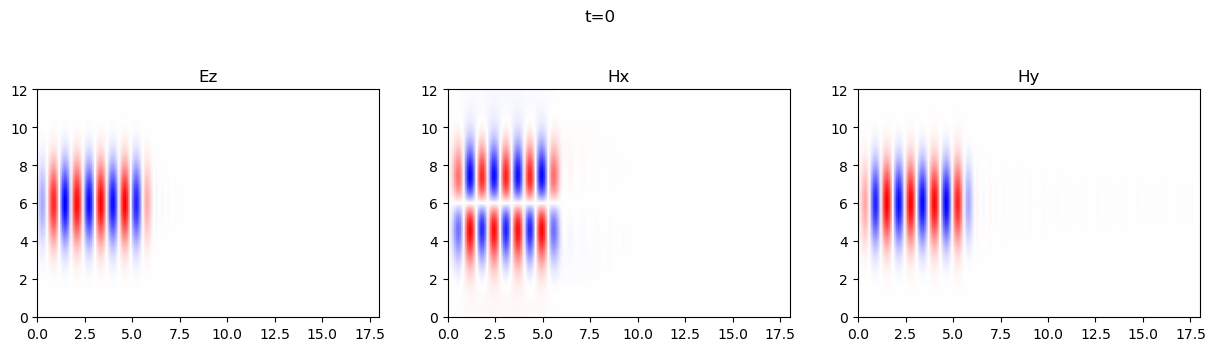

In [7]:
# 画初始波包
fig = plt.figure(figsize=(15, 4))
axes = fig.subplots(1, 3)
axes[0].imshow(Ez_init.T, cmap='bwr', origin='lower', extent=[0, 18, 0, 12])
axes[1].imshow(Hx_init.T, cmap='bwr', origin='lower', extent=[0, 18, 0, 12])
axes[2].imshow(Hy_init.T, cmap='bwr', origin='lower', extent=[0, 18, 0, 12])
axes[0].set_title('Ez')
axes[1].set_title('Hx')
axes[2].set_title('Hy')
fig.suptitle('t=0')
plt.show()

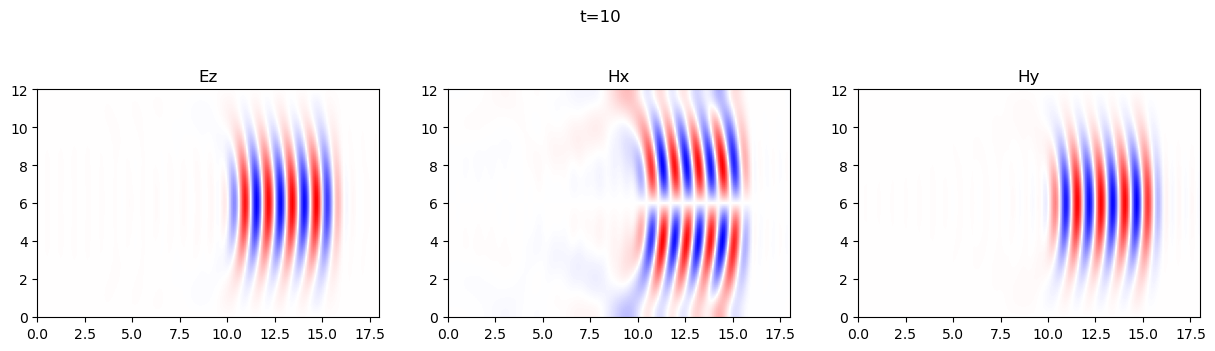

In [8]:
# 画 t=10 时刻的波包
fig = plt.figure(figsize=(15, 4))
axes = fig.subplots(1, 3)
axes[0].imshow(Ez_final.T, cmap='bwr', origin='lower', extent=[0, 18, 0, 12])
axes[1].imshow(Hx_final.T, cmap='bwr', origin='lower', extent=[0, 18, 0, 12])
axes[2].imshow(Hy_final.T, cmap='bwr', origin='lower', extent=[0, 18, 0, 12])
axes[0].set_title('Ez')
axes[1].set_title('Hx')
axes[2].set_title('Hy')
fig.suptitle('t=10')
plt.show()

In [9]:
# 用把 E 和 H 填入 Psi
Psi = np.zeros((nx, ny))
Psi[1::2, 1::2] = Ez_init  # 偶数项是 E_z
Psi[1::2, ::2] = Hx_init  # i 偶 j 奇是 H_x
Psi[::2, 1::2] = Hy_init  # i 奇 j 偶是 H_y

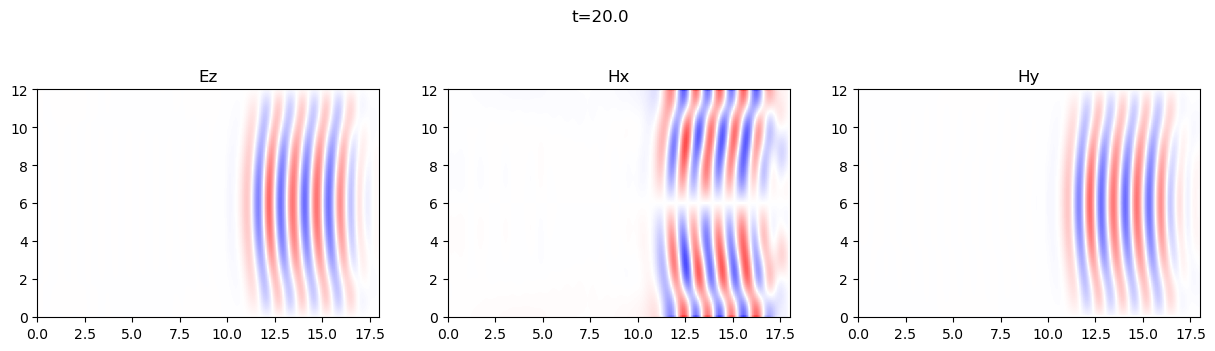

In [10]:
dt = 0.01
Psi_odd = np.copy(Psi)

fig = plt.figure(figsize=(15, 4))
axes = fig.subplots(1, 3)

for n_frame in range(100):  # 生成 100 张图像
    for i in range(20):  # 每张时间间隔 dt*20 = 0.2
        update_H(Psi, dt)
        update_E(Psi, dt)
    axes[0].imshow(Psi[1::2, 1::2].T, cmap='bwr', origin='lower', extent=[0, 18, 0, 12], vmin=-120, vmax=120)
    axes[1].imshow(Psi[1::2, ::2].T, cmap='bwr', origin='lower', extent=[0, 18, 0, 12], vmin=-10, vmax=10)
    axes[2].imshow(Psi[::2, 1::2].T, cmap='bwr', origin='lower', extent=[0, 18, 0, 12], vmin=-120, vmax=120)
    axes[0].set_title('Ez')
    axes[1].set_title('Hx')
    axes[2].set_title('Hy')
    fig.suptitle('t=%.1f' % (0.2*(n_frame+1)))
    fig.savefig(fname='./pic/t=%.1f.png' % (0.2*(n_frame+1)))